In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import utm
from datetime import datetime, timedelta


import matplotlib.animation as animation
from scipy.ndimage.filters import gaussian_filter

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor


## Map utils

In [4]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111



## Entreno el modelo que vamos a usar para predecir

In [5]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [6]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [7]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

## Levanto el archivo con las emisiones de los pajaros

In [8]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

## Levanto el archivo con los nidos

In [9]:
nests = sc.read.csv('datos/nidos_musico.csv', header=True).rdd

### Solo nos importa prepuesta y puesta

In [10]:
def format_date(date_str):
    if date_str is None:
        return None
    return datetime.strptime(date_str, '%m/%d/%Y').strftime('%Y-%m-%d') 
    
def format_row(row):
    res = {}
    lat, lon,_,_ = utm.from_latlon(float(row['Latitud']), float(row['Longitud']))
    res = {
        'lat': lat,
        'lon': lon,
        'nest_id': row['Nido'],
        'prepuesta_init': format_date(row['Inicio Prepuesta']),
        'prepuesta_end': format_date(row['Fin Prepuesta']),
        'puesta_init': format_date(row['Inicio Puesta']),
        'puesta_end': format_date(row['Fin Puesta']),
    }
    return res


    


In [11]:
nests = nests.map(format_row)

In [12]:
def get_bird_predictions(all_birds_recep, bird_tag_id, start_time, end_time):
    single_bird = all_birds_recep.filter(lambda x: x['tag_id'] == bird_tag_id).filter(lambda x: start_time <= x['timestamp'] <= end_time)
    if single_bird.count() == 0:
        return []
    birds_data = pd.DataFrame(single_bird.collect()).drop(columns=[4,5])
    predicted = predictor.predict(birds_data)
    predicted = pd.concat([pd.DataFrame(predicted), pd.DataFrame(single_bird.collect())], axis=1).values
    return predicted
    

In [13]:
def update_animation(data, p):
    x = data[0]
    y = data[1]
    p.set_data(x, y)
    plt.title(data[7])
    return p
 
    
def show_heatmap(bird_predictions, bird_id, nest):
    DELAY = 200

    fig, ax = plt.subplots()
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)
    all_points_pos = pd.DataFrame(data.map(lambda p: {'x': p['x'], 'y': p['y']}).collect())
    plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
    for antenna in np.arange(4):
            pos_antena = posicion_antenas[antenna]
            plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
            name = nombre_antenas[antenna]
            ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 
    
    plt.plot(nest['lat']-x_0, nest['lon']-y_0,"*y",markersize=10)
    
    range = np.array([[0,x_f-x_0],[0,y_f-y_0]])
    heatmap, xedges, yedges = np.histogram2d(bird_predictions[:,1], bird_predictions[:,0], bins=(64,64), range=range)
    extent = [0, x_f-x_0, 0, y_f-y_0]
    plt.imshow(gaussian_filter(heatmap, sigma=2, mode='nearest'), extent=extent, origin='lower', cmap=None)
    plt.title('Bird {}'.format(bird_id))
    #ani = animation.FuncAnimation(fig, update_animation, bird_predictions, interval=DELAY, fargs=(point,), repeat=False)
        

In [26]:
FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]


In [75]:
nest = nests.filter(lambda x: x['prepuesta_init'] is not None and x['prepuesta_init'] > '2018-01-10').take(1)[0]

<IPython.core.display.Javascript object>


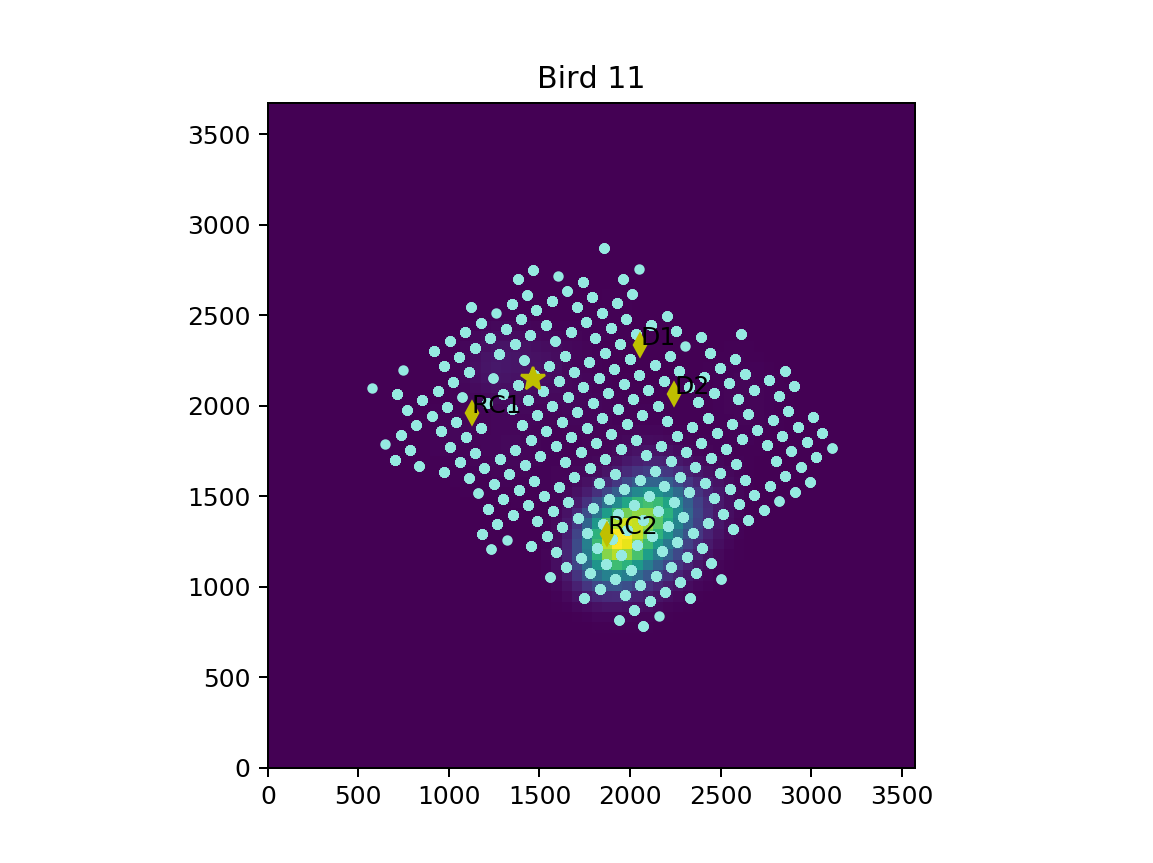

<IPython.core.display.Javascript object>


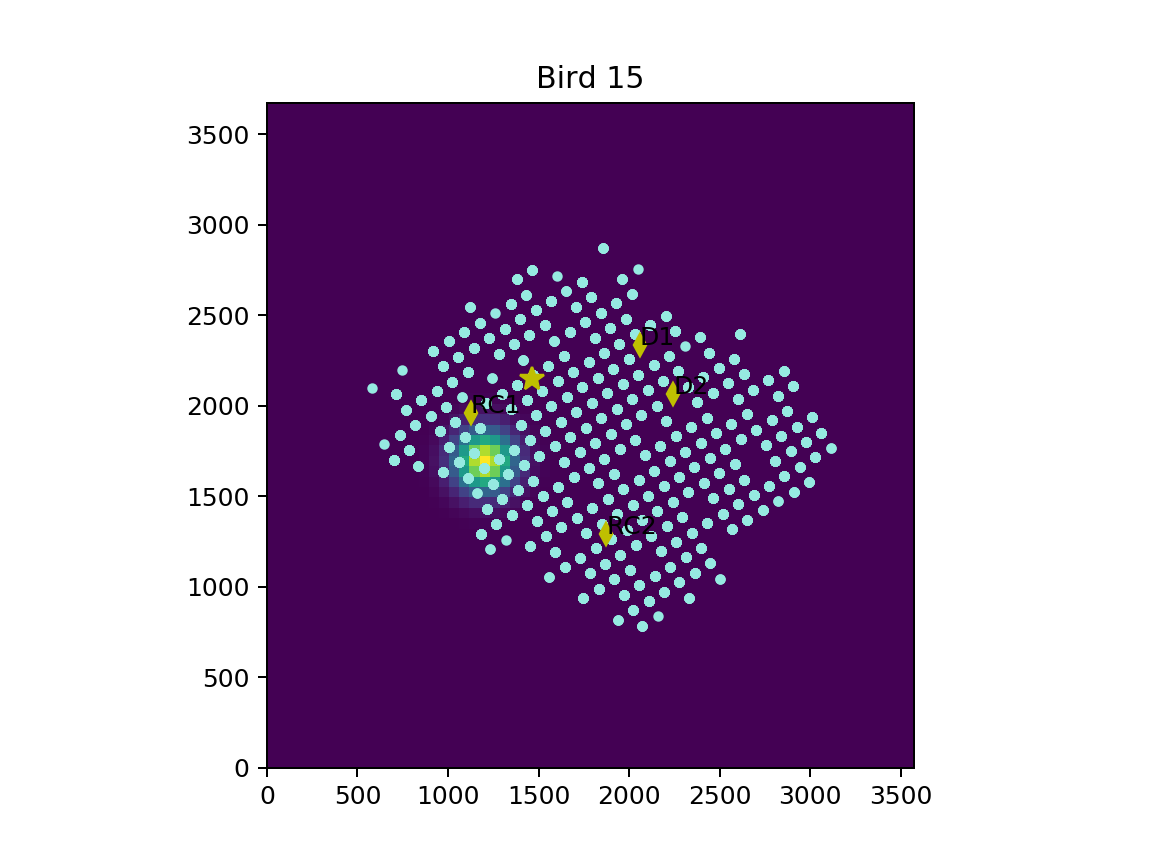

<IPython.core.display.Javascript object>


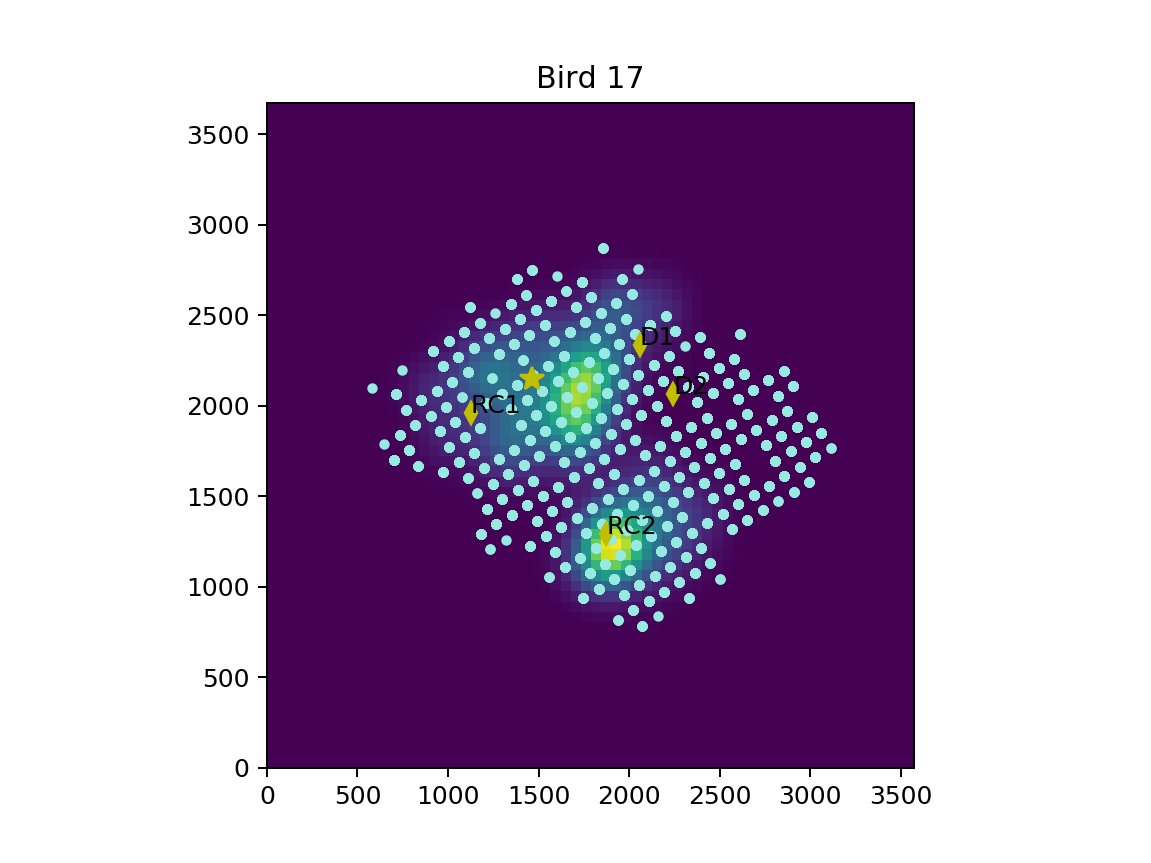

<IPython.core.display.Javascript object>


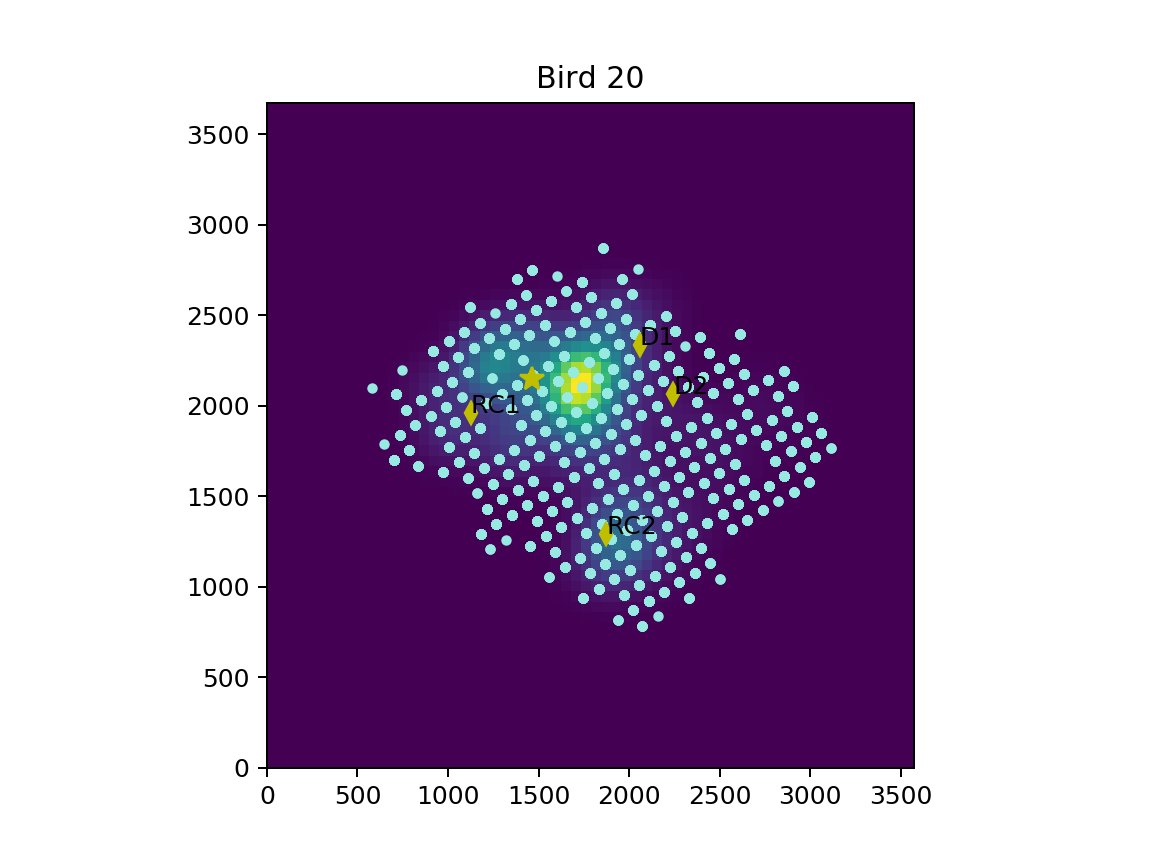

<IPython.core.display.Javascript object>


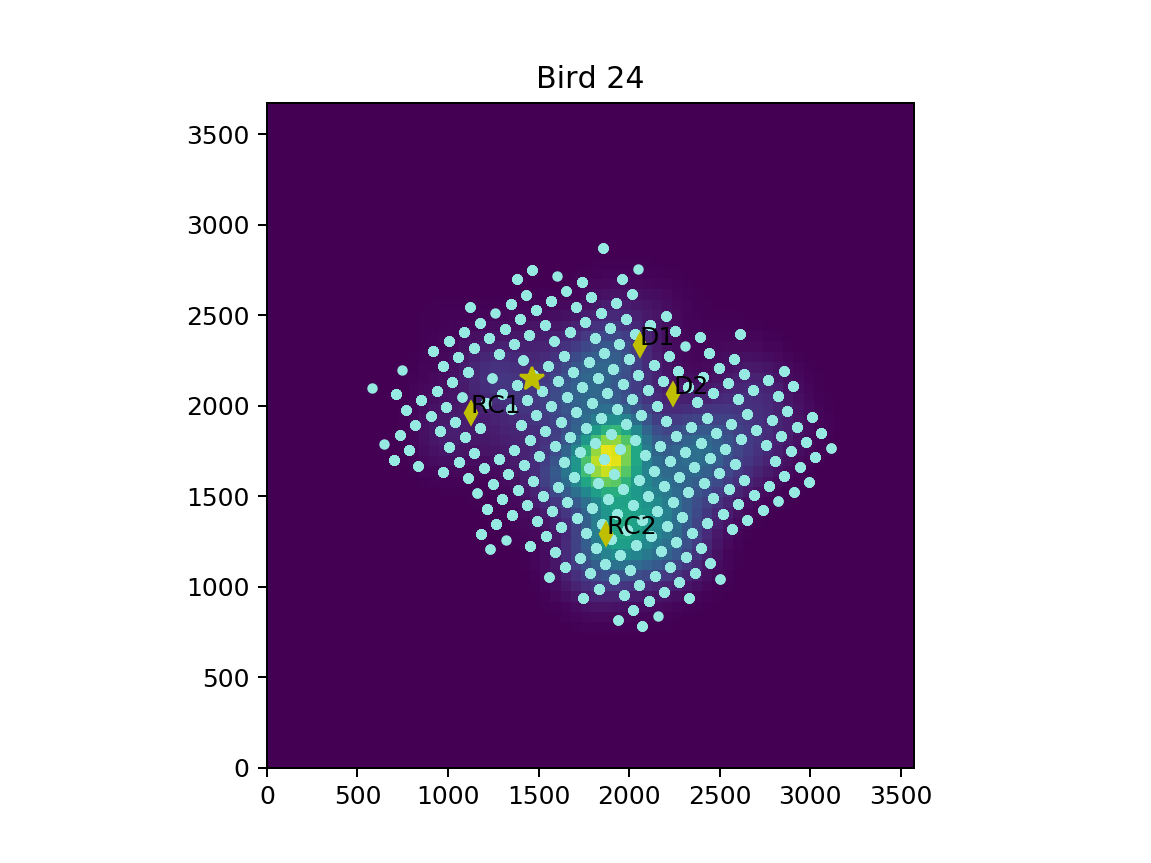

<IPython.core.display.Javascript object>


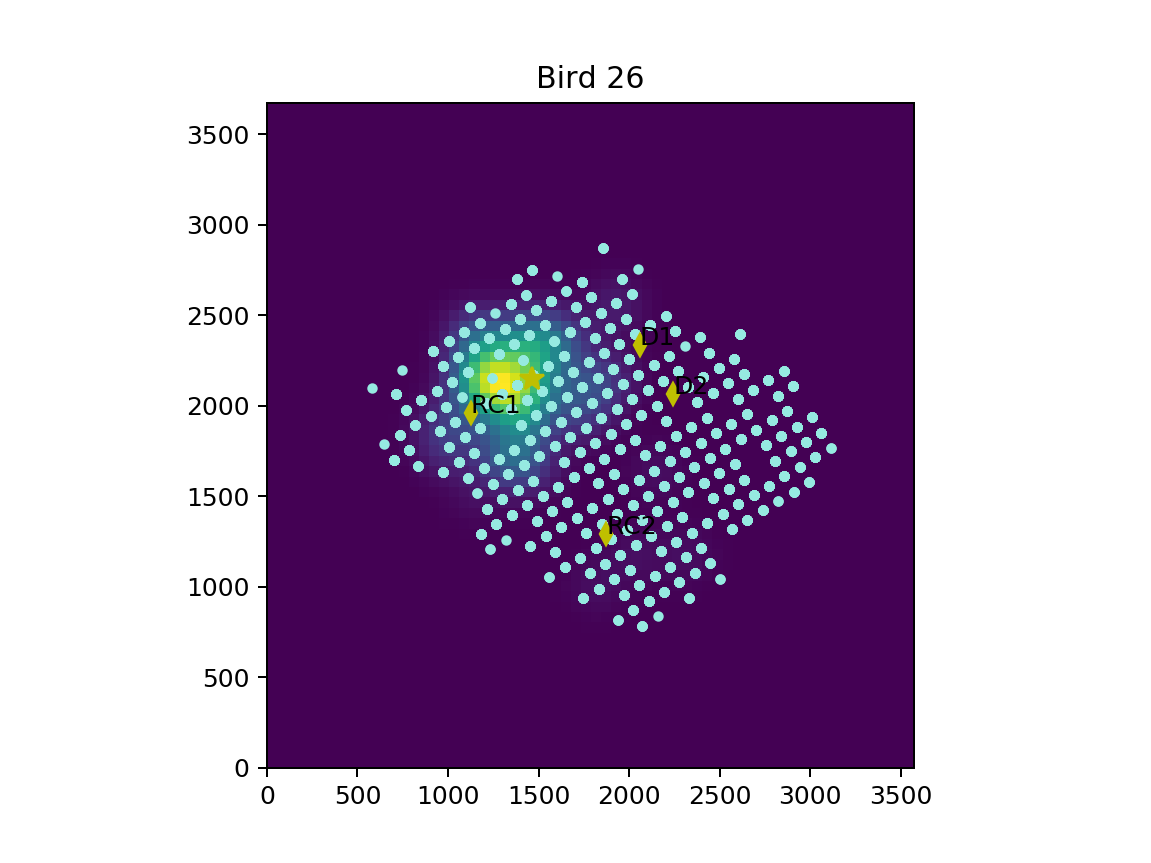

<IPython.core.display.Javascript object>


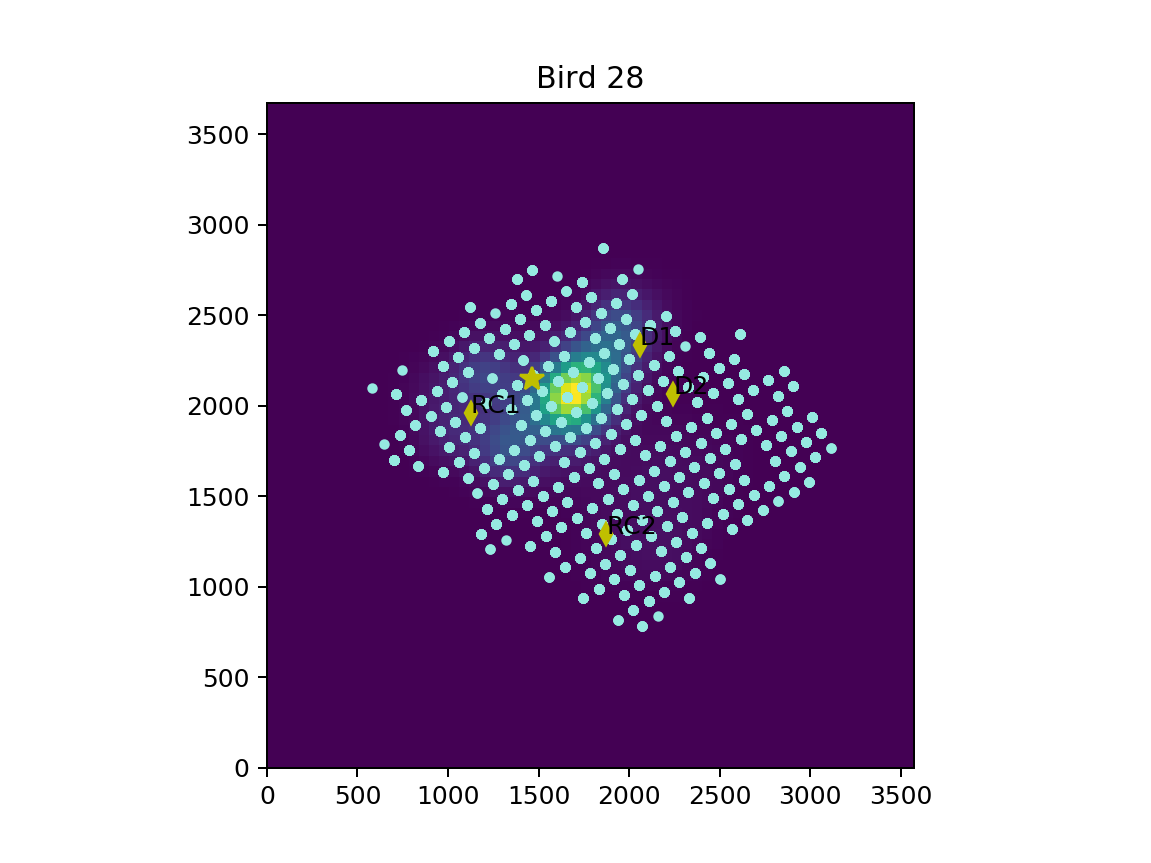

<IPython.core.display.Javascript object>


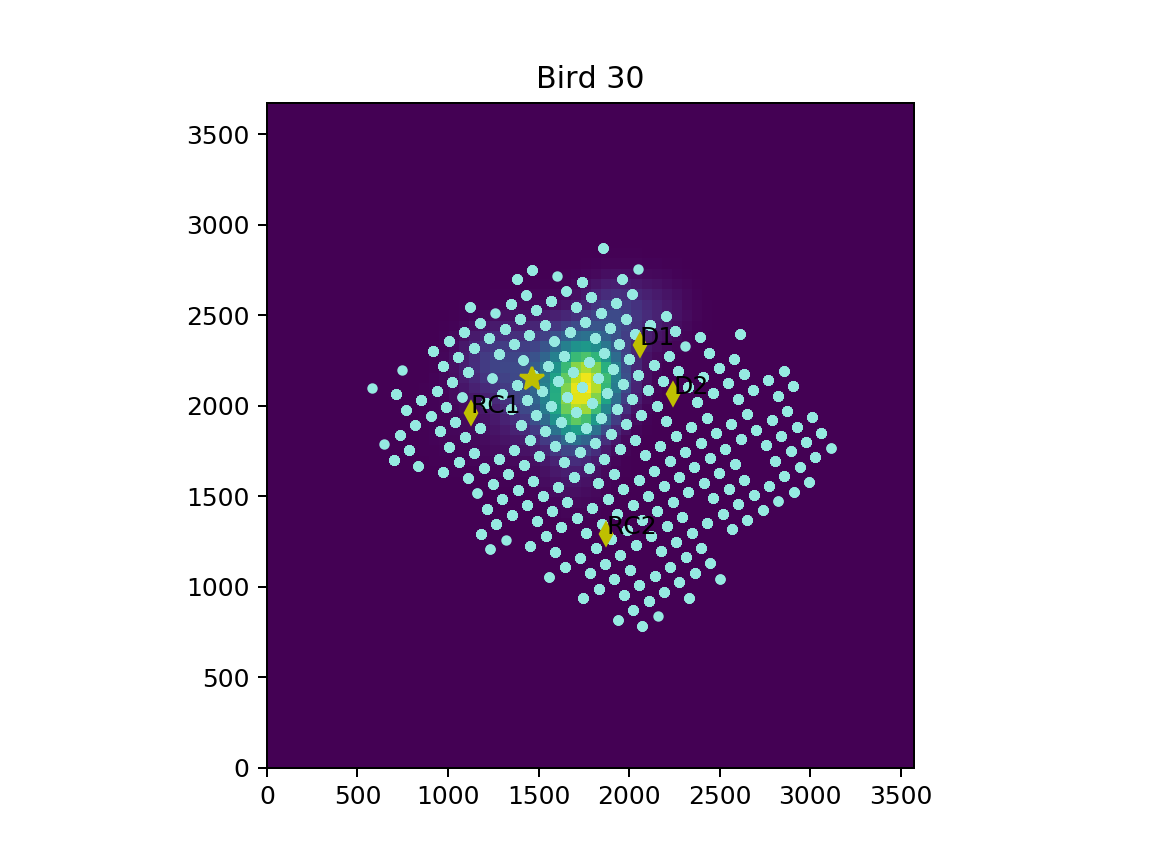

<IPython.core.display.Javascript object>


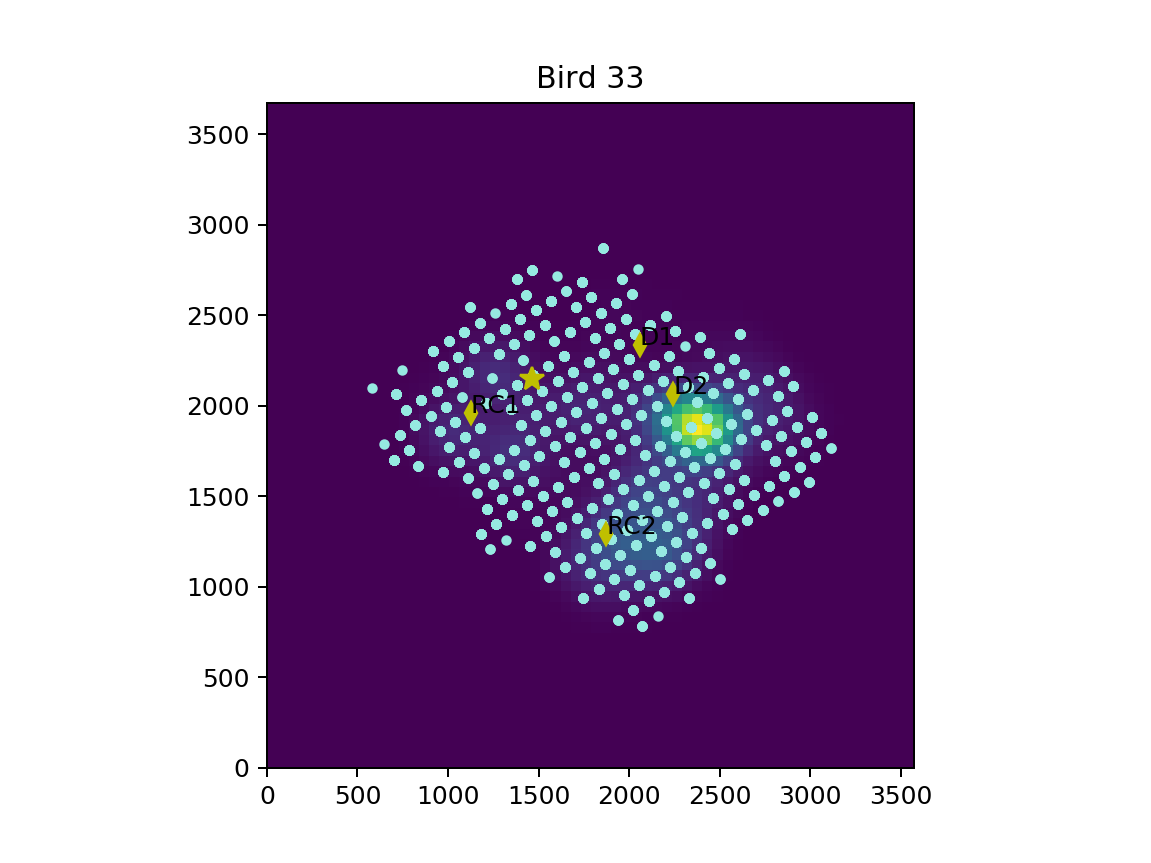

<IPython.core.display.Javascript object>


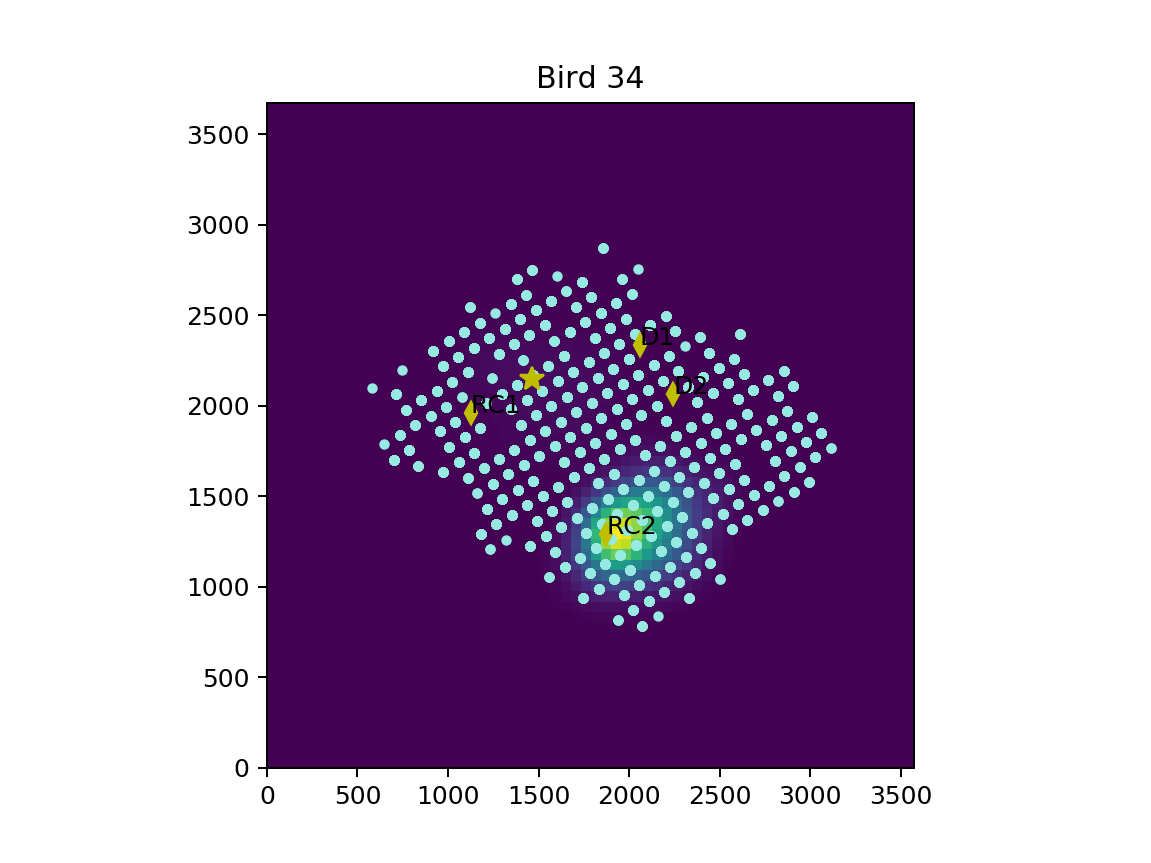

In [110]:
for female in FEMALES:
    predictions = get_bird_predictions(birds_recep, female,  start_time='2018-01-11 04:00:00', end_time='2018-01-11 18:00:00')
    if len(predictions) > 0:
        show_heatmap(predictions, female, nest)
        

In [23]:
nest = nests.filter(lambda x: x['puesta_init'] is not None).sortBy(lambda x: x['puesta_init'], ascending=False).take(10)[4]

In [24]:
nest

{'lat': 464489.4507907907,
 'lon': 6110122.9918795265,
 'nest_id': 'N33',
 'prepuesta_init': None,
 'prepuesta_end': None,
 'puesta_init': '2017-12-31',
 'puesta_end': '2018-01-01'}

<IPython.core.display.Javascript object>


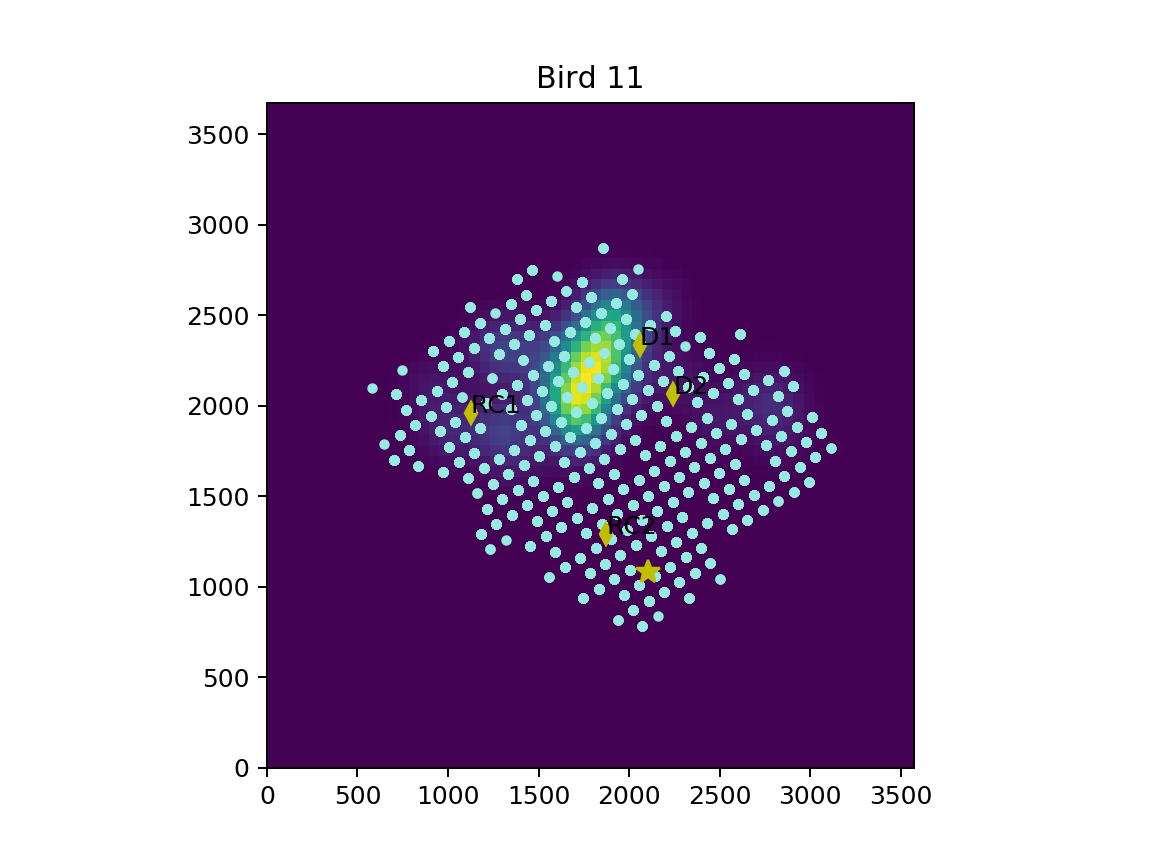

<IPython.core.display.Javascript object>


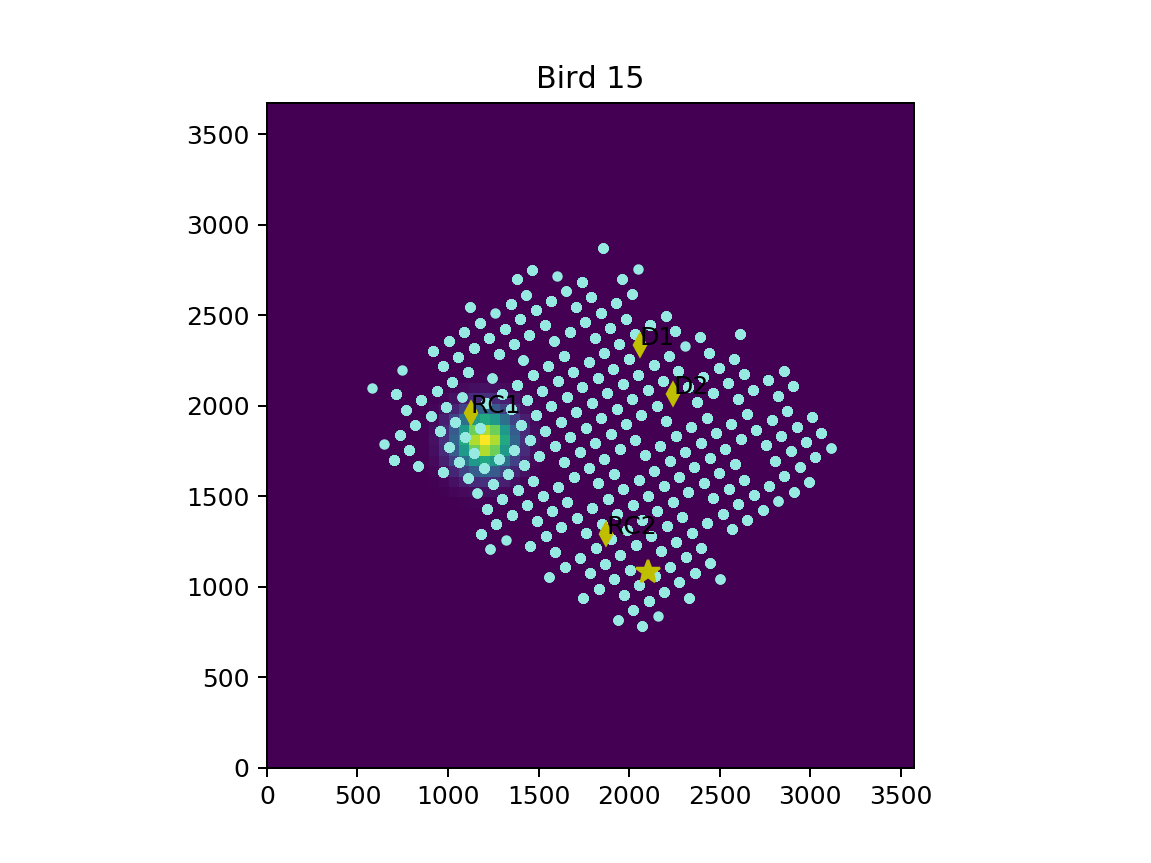

<IPython.core.display.Javascript object>


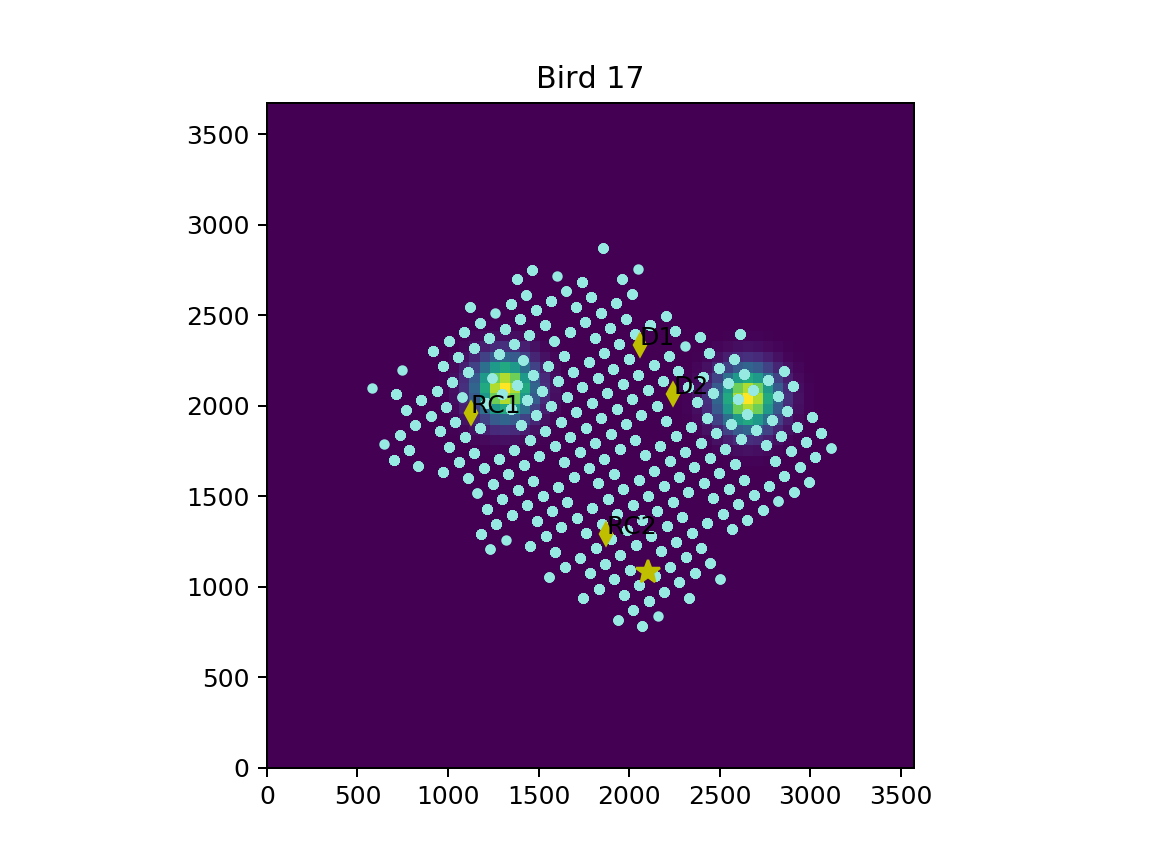

<IPython.core.display.Javascript object>


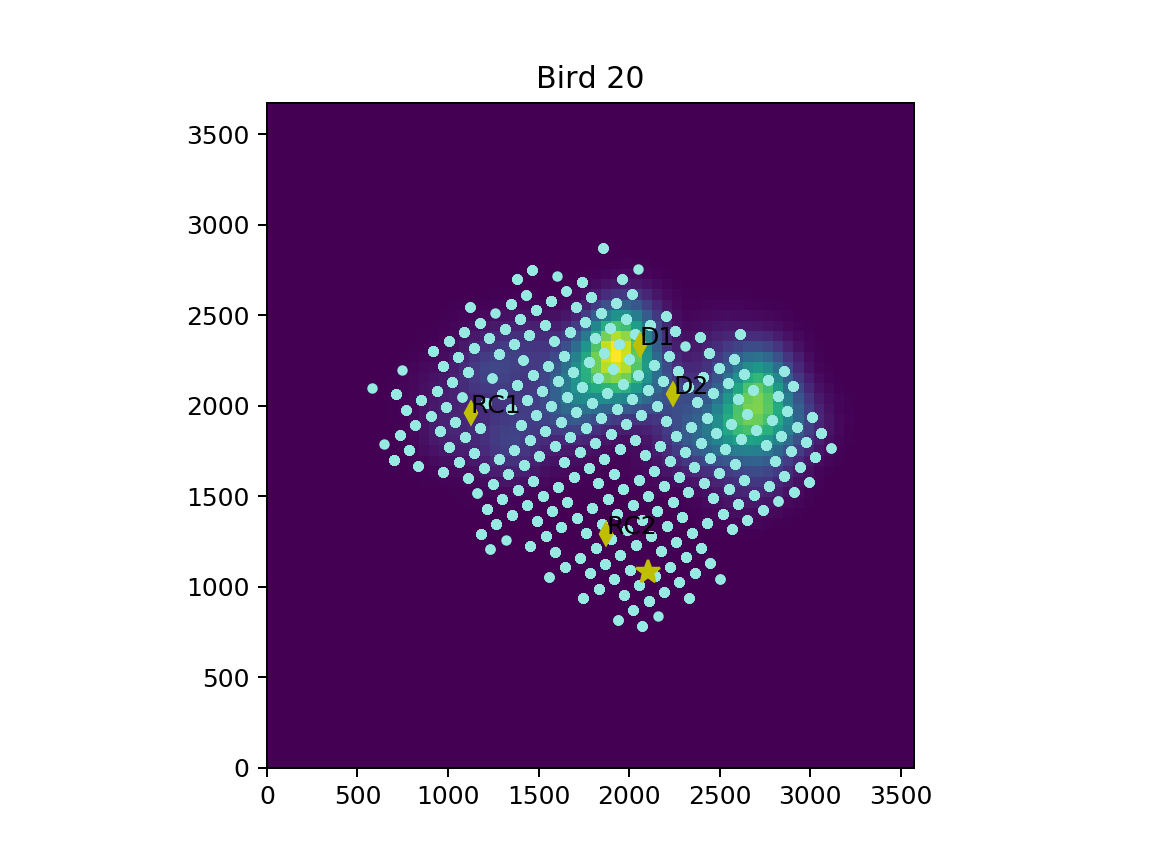

<IPython.core.display.Javascript object>


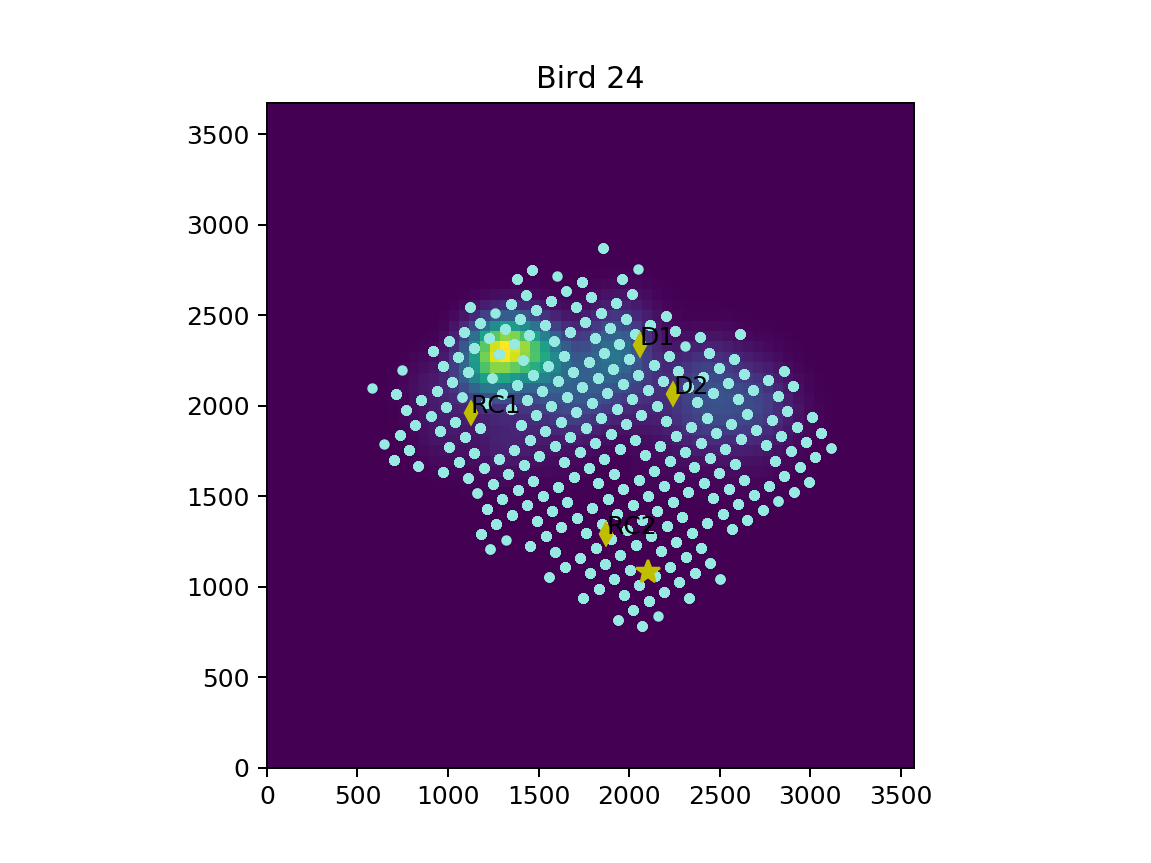

<IPython.core.display.Javascript object>


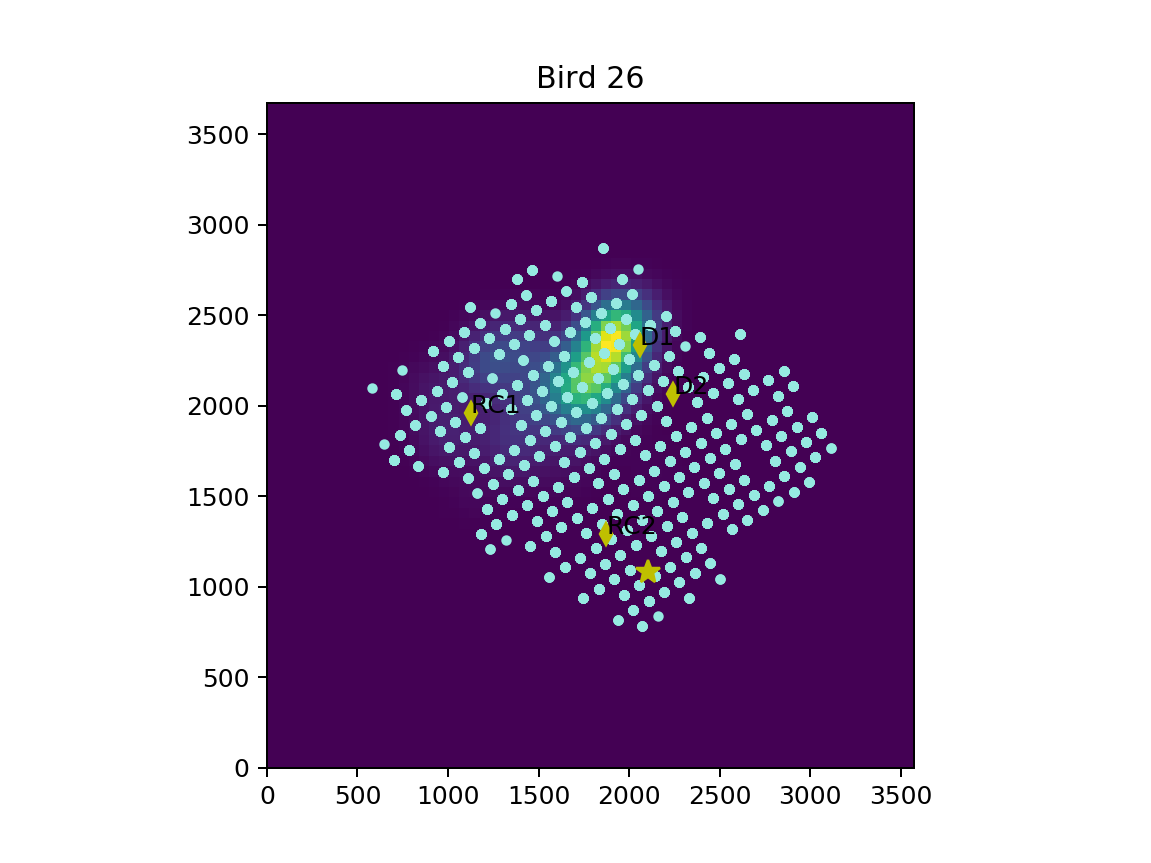

<IPython.core.display.Javascript object>


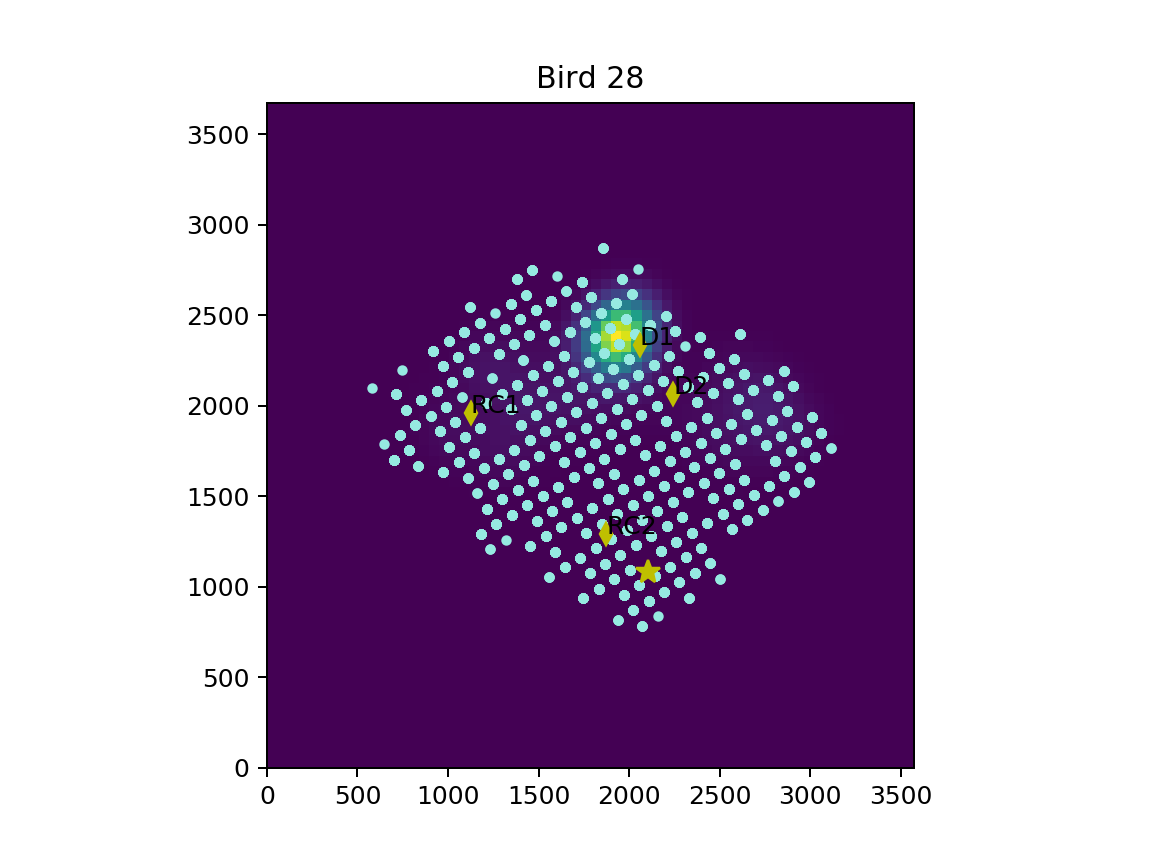

<IPython.core.display.Javascript object>


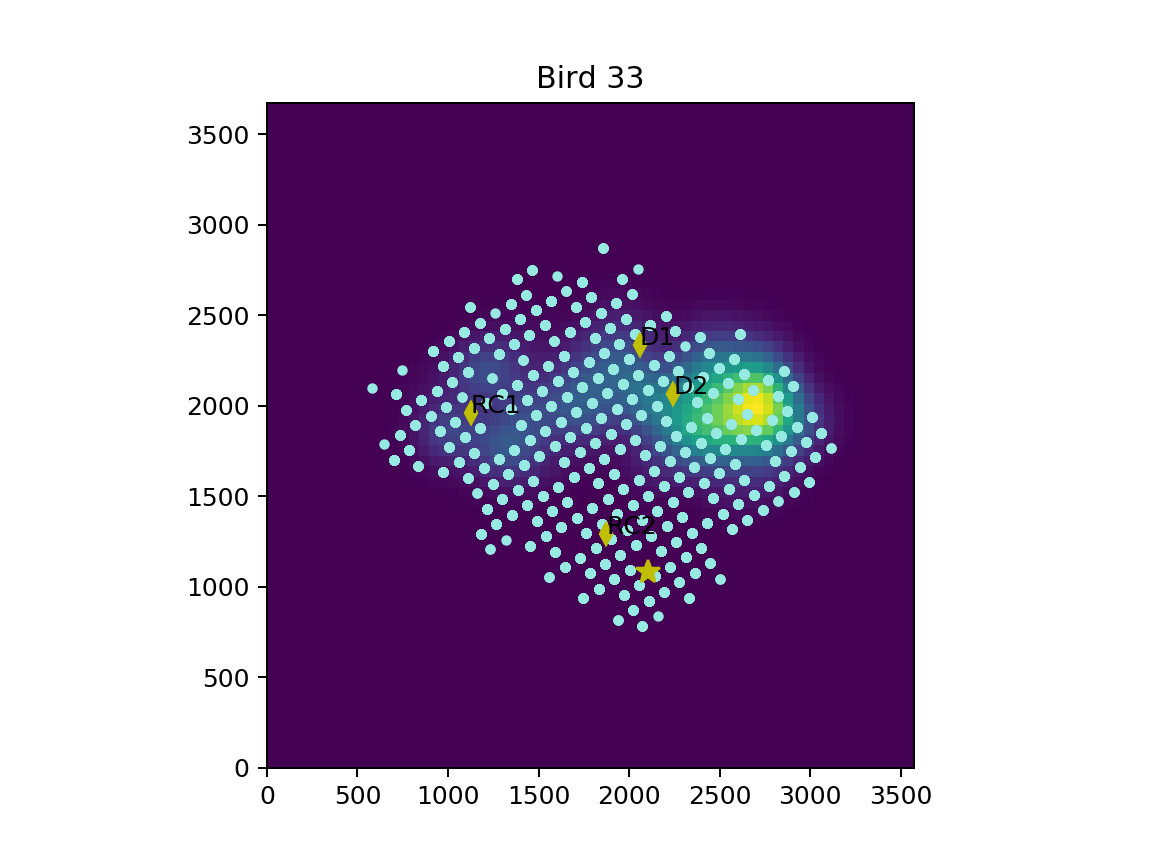

<IPython.core.display.Javascript object>


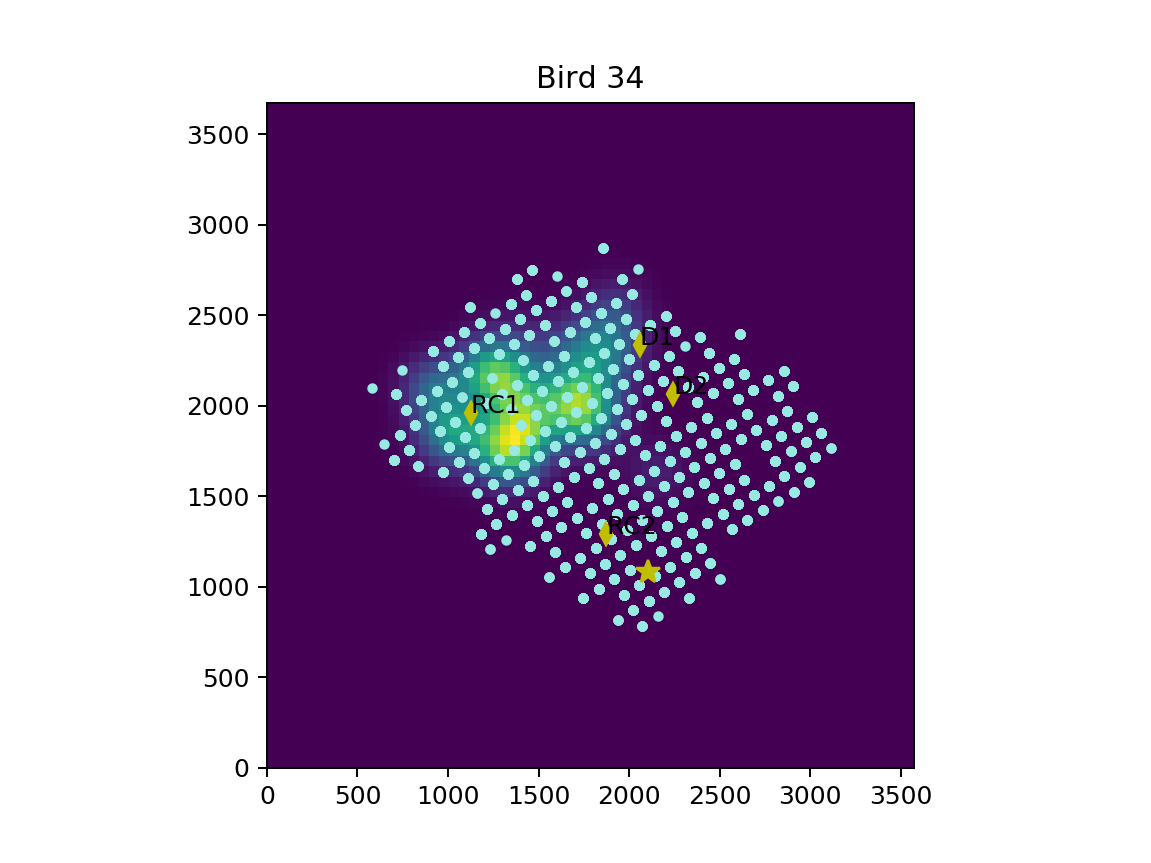

In [27]:
for female in FEMALES:
    predictions = get_bird_predictions(birds_recep, female,  start_time='2017-12-31 04:00:00', end_time='2017-12-31 10:00:00')
    if len(predictions) > 0:
        show_heatmap(predictions, female, nest)
        

## Preguntas

"qué tan fieles eran los individuos al dormidero y si bien la fidelidad era bastante alta (80-90% si no recuerdo mal)". Es 80% de los pajaros son fieles o todos los pajaros el 80% de las veces son fieles. Hay algunos pajaros que suelen dormir menos en el dormidero?



-- Que horarios es mejor analizar? 04:00 a 10:00? Todo el dia?

*de 04:30 a 06:00 es el horario de parasitismo. Pero todo el dia pueden estar cerca de nidos activos*



-- Una hembra puede monitorear distintos nidos? Un nido puede ser monitoreado por muchas hembras?

*Los pajaros tienen un area en la que suelen moverse y no suelen salirse mucho de ese area. Varias hembras podrian monitorear el mismo nido.*



-- Romina tiene etiquetado que pajaros estuvieron monitoreando los nidos?

*Tenemos datos de la posicion de algunos pajaros en algun momento*




La idea de esta parte es ver si los individuos pasan más tiempo alrededor de esas áreas cuando los nidos están activos (prepuesta y puesta más que nada, en incubación y pichones no lo esperamos tanto). La idea sería comparar la ocurrencia de los individuos en esos puntos en las fechas de prepuesta-puesta y compararla contra el periodo de pichones, o en fechas alejadas de la "ventana de actividad".




Tambien interesa saber si los machos acompañan a las hembras?

04:30 a 06:00 es el horario de parsitismo (cuando salen a poner huevos).
El resto del dia recorren campo y visitan nidos

cuando las hembras salen a parasitar salen mas temprano

comparacion en horario en parasitismo y horario no parasitismo
